In [4]:
#This notebook is split into two parts.

#PART 1 uploads market data for USD interest rate swaps (can easily change to overnight index swaps)
#from Bloomberg's API, using Brian Smith's beautiful TIA wrapper (https://github.com/bpsmith/tia),
#which converts the data into a panda dataframe.
#Data feed can replaced with a different provider, or skipped with instruments keyed manually in PART 2.

#If you have no data source, you can go directly to PART 2, keying data manually.  

##### PART 1 of 2 ######

#for BLPAPI to work, copy blpapi folder into your Python Anaconda directory.
#mine is  C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\lib\site-packages\ 

#Make SURE it includes the blpapi3_64.dll from Bloomberg's installer directory: C:\blp\API\APIv3\C++API\v3.8.13.1\lib
#then go to Start, type PATH
#add as VariableValue:
#C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\Lib\site-packages\blpapi '''

import blpapi #to retrieve real time market data from Bloomberg
from tia.bbg import LocalTerminal  #to have the data from Bloomberg in a presentable, dataframe table fashion
import pandas as pd #to access dataframes
import numpy as np #to interpolate missing market data points, like 16year or 23year swaps
import matplotlib.pylab as plt # to plot graphs

import datetime  
today = pd.datetime.today()

In [5]:
#for graphs to be contained inside notebook
%matplotlib inline  

In [6]:
#like with BLPAPI, download the TIA package from GitHub and paste in the directory:
#C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\Lib\site-packages\tia

#There was a NameError when calling 'resp', 'basestring' not defined
#from C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\lib\site-packages\tia\bbg\v3api.py 

#So had to change all them to 'str', close-re-open and then it worked :)

#Examples :  http://nbviewer.jupyter.org/github/bpsmith/tia/blob/master/examples/v3api.ipynb '''

In [7]:
#import USD IRS swaps from 1y to 30yrs and save into a panda dataframe
df = LocalTerminal.get_historical(['USSA1 Curncy','USSA2 Curncy', 'USSA3 Curncy',\
                                      'USSA4 Curncy', 'USSA5 Curncy', 'USSA6 Curncy', \
                                      'USSA7 Curncy', 'USSA8 Curncy', 'USSA9 Curncy', \
                                      'USSA10 Curncy','USSA11 Curncy', 'USSA12 Curncy',\
                                     'USSA15 Curncy', 'USSA20 Curncy',\
                                    'USSA25 Curncy', 'USSA30 Curncy'],'PX_LAST', \
                                    start= today, end= today, period = 'DAILY')
USSA = df.as_frame().tail()
USSA #this is a multi index dataframe with: 'USSA_year Currency' and 'PX_LAST' as indeces.  

,USSA7 Curncy,USSA11 Curncy,USSA8 Curncy,USSA5 Curncy,USSA30 Curncy,USSA20 Curncy,USSA15 Curncy,USSA4 Curncy,USSA10 Curncy,USSA1 Curncy,USSA9 Curncy,USSA12 Curncy,USSA2 Curncy,USSA25 Curncy,USSA3 Curncy,USSA6 Curncy
,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
date,,,,,,,,,,,,,,,,
2017-11-08,2.1445,2.3015,2.1895,2.0406,2.4912,2.4638,2.4004,1.9837,2.2684,1.657,2.2315,2.3345,1.8173,2.4874,1.9144,2.0942


In [8]:
#remove the "PX_LAST" index
USSA.columns = USSA.columns.get_level_values(0)
USSA

,USSA7 Curncy,USSA11 Curncy,USSA8 Curncy,USSA5 Curncy,USSA30 Curncy,USSA20 Curncy,USSA15 Curncy,USSA4 Curncy,USSA10 Curncy,USSA1 Curncy,USSA9 Curncy,USSA12 Curncy,USSA2 Curncy,USSA25 Curncy,USSA3 Curncy,USSA6 Curncy
date,,,,,,,,,,,,,,,,
2017-11-08,2.1445,2.3015,2.1895,2.0406,2.4912,2.4638,2.4004,1.9837,2.2684,1.657,2.2315,2.3345,1.8173,2.4874,1.9144,2.0942


In [9]:
#the columns are in a weird order. So we relabel them dropping the "Curncy" suffix, which is 6 letters, 
#so that we can sort them
USSA = USSA.rename(columns = lambda x : str(x)[:-6]) 
#this iterates through the columns and apply some function.
#In this case, the function converts something into a string and takes everything up until the last 6 characters, ie the "Curncy"
USSA

,USSA7,USSA11,USSA8,USSA5,USSA30,USSA20,USSA15,USSA4,USSA10,USSA1,USSA9,USSA12,USSA2,USSA25,USSA3,USSA6
date,,,,,,,,,,,,,,,,
2017-11-08,2.1445,2.3015,2.1895,2.0406,2.4912,2.4638,2.4004,1.9837,2.2684,1.657,2.2315,2.3345,1.8173,2.4874,1.9144,2.0942


In [10]:
#..sort them and  divide by 100 as BBG data is 1.605%
USSA = USSA.reindex_axis(sorted(USSA.columns, key = lambda x: float(x[4: ])),axis = 1).divide(100, axis = 'columns')
USSA

,USSA1,USSA2,USSA3,USSA4,USSA5,USSA6,USSA7,USSA8,USSA9,USSA10,USSA11,USSA12,USSA15,USSA20,USSA25,USSA30
date,,,,,,,,,,,,,,,,
2017-11-08,0.01657,0.018173,0.019144,0.019837,0.020406,0.020942,0.021445,0.021895,0.022315,0.022684,0.023015,0.023345,0.024004,0.024638,0.024874,0.024912


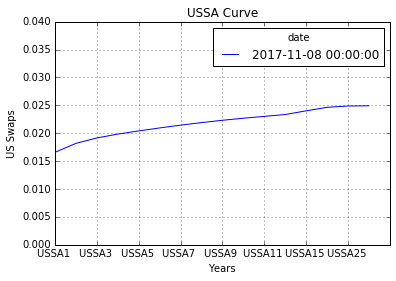

In [11]:
#want to graph yield curve?
transp = USSA.transpose()  #first transpose, so that 1x30 matrix becomes 30rows (one per year) x 1 column (for values)
transp.plot(color = 'blue')

plt.title('USSA Curve')
plt.xlabel('Years')
plt.ylabel('US Swaps')

#set limits
plt.xlim(0,16)
plt.ylim(0, 0.04)

plt.grid('on')
plt.show()

In [12]:
#sanity check
USSA.iloc[0,0], USSA.iloc[0, 1], USSA.iloc[0, 2], USSA.iloc[0, 3], USSA.iloc[0, 4]

(0.016570000000000001,
 0.018172999999999998,
 0.019144000000000001,
 0.019837,
 0.020406000000000001)

In [13]:
#####PART 2 of 2######

'''implementation of "forward_substitution" from https://en.wikipedia.org/wiki/Bootstrapping_(finance)
Namely extracting discount_factors from market traded yield_curve_instruments, which are futures and deposits up to 1year,
and interest (IRS) or overnight indexed swaps (OIS) from 1year onwards.  

Key concept on a fixed IRs: fair value is 0 at start, via no-arbitrage argument, assuming a notional of $1. Thus:

1year_IRS:  disc_factor1* ($1 + coup_1 * act/360) = $1   
2year_IRS:  disc_factor1 * coup_2 + disc_factor2*($1 + coup_2 * act/360) = $1
3year_IRS:  disc_factor1 * coup_3 + disc_factor2 * coup3 + disc_factor3 * ($1 + coup_3) = $1


Variation of Chapter5 from James WeiMing Ma "Mastering Python For Finance"   '''

import math

class GetDiscFactors(object):
   
    def __init__(self):
        
        self.instr = {}  #populated using add_instr() method
        self.disc_factors = {}
        self.zero_rates = {}
       
    def add_instr(self, par , T, coup, price , freq = 1): 
        
        #par and price only relevant for eurodollar futures, on IRS or OIS = $1 for both
       
        self.instr[T] = (par, coup, price, freq)
       
        '''dictionary with keys: T years grouping of tuples for vals:
            {0.25: (1, 0.0, 0.9849, 1),
             0.5: (1, 0.0, 0.9837, 1),
             1: (1, 0.013855, 1, 1),
             2: (1, 0.015271, 1, 1),
             3: (1, 0.01622, 1, 1)}
             and so forth'''
   
    def sort_instr(self):
       
        sort_dict = sorted(self.instr.keys())
        return sort_dict
    
    def get_df(self):
        #uses 2 helper methods below
        self.__get_shortdated_df__()
        self.__get_longdated_df__()
        return [self.disc_factors[i] for i in self.sort_instr()] #without this, get_df does not return anything.
        #you can still access disc_factors by calling rateObject.disc_factors
   
    def __get_shortdated_df__(self):
        
        '''Say eurodolly future price is 98.46 and there are 62days to next IMM date.
        thus yield is 100% - 98.46% = 1.54% p.a., thus disc_factor will be 1/(1+1.54%*62/360)  '''
        
        for T in self.instr:
           
            (par, coup, price, freq) = self.instr[T]  #without this: NameError: name 'coup' is not defined
            
            if coup == 0:
                self.disc_factors[T] = 1.0 / (1.0 + (1.0 - price)*T)
                #print(self.disc_factors.values())
    
    def __get_longdated_df__(self):
        #for T in self.instr:  #goes from 0.25, 0.50 straight to 2 skipping T = 1
        for T in self.sort_instr():
            
            #(par, coup, price, freq) = self.instr[T]
            instrument = self.instr[T]
            (par, coup, price, freq) = instrument  #without this; NameError: name 'coup' is not defined
            
            '''there is no need to 'bootstrap' for non coupon bearing instruments so by definition this procedure starts
            at T = 1yr. Year1 disc_factor is simply 1/1+ rate_y1 
            which we access in the dictionary, key = 1, and the 'coup' (ie [1]) column entry of the tuple '''
            
            self.disc_factors[1] = 1.0 / (1.0 + self.instr[1][1]*365.0/360.0)
            if coup != 0:
                for i in range(2, T+1):
                    sum_coup = 0
                    for k in range(1, i):
                        sum_coup += self.disc_factors[k] *self.instr[i][1] *365.0 / 360.0
                    self.disc_factors[i] = (1 - sum_coup) / (1 + self.instr[i][1]*365.0/360.0)
                    
            #return self.disc_factors
                    
    def get_zero_rates(self):
        
        #converts from discount factor to zero rate
        disc_factors = self.get_df() #returns a single list of dfs so use below instead
        disc_fact_dict = self.disc_factors #returns a dictionary
        zeroes = []
        for t, df in sorted(disc_fact_dict.items()):
            #zeroes.append(((1.0/df)**(1/t)) -1.0)
            self.zero_rates[t] = (((1.0/df)**(1/t)) -1.0)
        return(self.zero_rates) #[i] for i in self.zero_rates

                                  

In [19]:
curve = GetDiscFactors()
curve.add_instr(1, 0.25, 0., 0.9849)      # T = 0.25,   element 0
curve.add_instr(1, 0.50 , 0., 0.9837)     #  T = 0.50  element 1


#if yuo dont' have access to a data feed, just overwrite the "USSA.iloc[0,n] below with actual swap rates..

                                      
#curve.add_instr(1, 1, USSA.iloc[0,0], 1)  #Year 1   
#curve.add_instr(1, 2, USSA.iloc[0,1], 1) #Year 2   
#curve.add_instr(1, 3, USSA.iloc[0,2], 1) #Year 3  
#curve.add_instr(1, 4, USSA.iloc[0,3], 1) #Year 4  
#curve.add_instr(1, 5, USSA.iloc[0,4], 1) #Year 5  
#curve.add_instr(1, 6, USSA.iloc[0,5], 1) #Year 6  
#curve.add_instr(1, 7, USSA.iloc[0,6], 1) #Year 7  
#curve.add_instr(1, 8, USSA.iloc[0,7], 1) #Year 8  
#curve.add_instr(1, 9, USSA.iloc[0,8], 1) #Year 9  
#curve.add_instr(1, 10, USSA.iloc[0,9], 1) #Year 10  
#curve.add_instr(1, 11, USSA.iloc[0,10], 1) #Year 11 
#curve.add_instr(1, 12, USSA.iloc[0,11], 1) #Year 12 


#populate first 14years 
for year in range(1, 14):
    curve.add_instr(1, year, USSA.iloc[0, year -1], 1)
    
    
#populate other major points, like year 15, 20, 25 and 30
    
curve.add_instr(1, 15, USSA.iloc[0,12], 1) #Year 15
curve.add_instr(1, 20, USSA.iloc[0,13], 1) #Year 20 
curve.add_instr(1, 25, USSA.iloc[0,14], 1) #Year 25
curve.add_instr(1, 30, USSA.iloc[0,15], 1) #Year 30 '''


#interpolate the missing points, like year 13 , 14...24

x = sorted(curve.instr.keys())
y = [curve.instr[i][1] for i in curve.instr]


us13 = np.interp(13, x, y)
curve.add_instr(1, 13, us13, 1) #Year 13   
us14 = np.interp(14, x, y)
curve.add_instr(1, 14, us14, 1) #Year 14 

us16 = np.interp(16, x, y)
curve.add_instr(1, 16, us16, 1) #Year 16 
us17 = np.interp(17, x, y)
curve.add_instr(1, 17, us14, 1) #Year 17 
us18 = np.interp(18, x, y)
curve.add_instr(1, 18, us18, 1) #Year 18 
us19 = np.interp(19, x, y)
curve.add_instr(1, 19, us19, 1) #Year 19

us21 = np.interp(21, x, y)
curve.add_instr(1, 21, us21, 1) #Year 21
us22 = np.interp(22, x, y)
curve.add_instr(1, 22, us22, 1) #Year 22
us23 = np.interp(23, x, y)
curve.add_instr(1, 23, us23, 1) #Year 23
us24 = np.interp(24, x, y)
curve.add_instr(1, 24, us24, 1) #Year 24
us26= np.interp(26, x, y)
curve.add_instr(1, 26, us26, 1) #Year 26
us27 = np.interp(27, x, y)
curve.add_instr(1, 27, us27, 1) #Year 27
us28 = np.interp(28, x, y)
curve.add_instr(1, 28, us28, 1) #Year 28
us29 = np.interp(29, x, y)
curve.add_instr(1, 29, us29, 1) #Year 29


curve.instr

{0.25: (1, 0.0, 0.9849, 1),
 0.5: (1, 0.0, 0.9837, 1),
 1: (1, 0.016570000000000001, 1, 1),
 2: (1, 0.018172999999999998, 1, 1),
 3: (1, 0.019144000000000001, 1, 1),
 4: (1, 0.019837, 1, 1),
 5: (1, 0.020406000000000001, 1, 1),
 6: (1, 0.020941999999999999, 1, 1),
 7: (1, 0.021444999999999999, 1, 1),
 8: (1, 0.021894999999999998, 1, 1),
 9: (1, 0.022315000000000002, 1, 1),
 10: (1, 0.022684000000000003, 1, 1),
 11: (1, 0.023014999999999997, 1, 1),
 12: (1, 0.023345000000000001, 1, 1),
 13: (1, 0.024003999999999998, 1, 1),
 14: (1, 0.023509499999999996, 1, 1),
 15: (1, 0.024003999999999998, 1, 1),
 16: (1, 0.0233396, 1, 1),
 17: (1, 0.023509499999999996, 1, 1),
 18: (1, 0.023988799999999998, 1, 1),
 19: (1, 0.0243134, 1, 1),
 20: (1, 0.024638, 1, 1),
 21: (1, 0.0246852, 1, 1),
 22: (1, 0.0247324, 1, 1),
 23: (1, 0.0247796, 1, 1),
 24: (1, 0.0248268, 1, 1),
 25: (1, 0.024874, 1, 1),
 26: (1, 0.0248816, 1, 1),
 27: (1, 0.0248892, 1, 1),
 28: (1, 0.0248968, 1, 1),
 29: (1, 0.0249044, 1, 1)

In [15]:
#check output! below returns dictionary of disc_factor
#On 8November2017, BBG had 
#10yr df of 0.7949 vs 0.7951 
#15yr df of 0.6936 vs 0.6939
#30yr df of 0.4677 vs 0.4678
curve.get_df() #need this to fill up dictionary
curve.disc_factors

{0.25: 0.9962391970312071,
 0.5: 0.9919158855329067,
 1: 0.98347744237402701,
 2: 0.96411482797198811,
 3: 0.94387690458886664,
 4: 0.92327588696006746,
 5: 0.90240491857490079,
 6: 0.88113244676181612,
 7: 0.85958752034877817,
 8: 0.83803744252276935,
 9: 0.81645828984979107,
 10: 0.79513587683425224,
 11: 0.77408357266571814,
 12: 0.75302084740728337,
 13: 0.7319671427987926,
 14: 0.71868894278007911,
 15: 0.69385708541891034,
 16: 0.68609513805056055,
 17: 0.67016492871329369,
 18: 0.6453674047404605,
 19: 0.62515793737454195,
 20: 0.6050395420617678,
 21: 0.58952816027625987,
 22: 0.57434118134485834,
 23: 0.55947278170157622,
 24: 0.54491722128392228,
 25: 0.5306688428184767,
 26: 0.51747110778279337,
 27: 0.50459044008888243,
 28: 0.4920193236205187,
 29: 0.47975041806546637,
 30: 0.46777655486025266}

In [16]:
#check output! below returns dictionary of zero_rates
#On 8November2017, BBG had: 
#10yr zero of 2.3090 vs 2.3189
#15yr zero of 2.45373 vs 2.4665
#30yr zero of 2.5486 vs 2.5649

curve.get_zero_rates()
curve.zero_rates

{0.25: 0.015185719137518205,
 0.5: 0.0163664225000002,
 1: 0.016800138888888982,
 2: 0.018440400113045596,
 3: 0.019439710565658297,
 4: 0.020157264887043613,
 5: 0.02075075364389467,
 6: 0.021315213038496372,
 7: 0.021849950730366219,
 8: 0.022332276109768401,
 9: 0.022786791423464736,
 10: 0.023189005964367126,
 11: 0.023552669631389023,
 12: 0.023920135070488291,
 13: 0.024291866375693916,
 14: 0.023875318549772651,
 15: 0.024665226788888273,
 16: 0.023825586041887004,
 17: 0.023822350335668041,
 18: 0.024628133579363665,
 19: 0.025031900770432047,
 20: 0.025441317118625406,
 21: 0.025482738599393207,
 22: 0.025526341657159168,
 23: 0.02557194508301186,
 24: 0.025619401586268076,
 25: 0.025668591174875521,
 26: 0.025662271548690496,
 27: 0.025657260257725412,
 28: 0.025653430992586879,
 29: 0.025650675239971887,
 30: 0.025648899326962571}

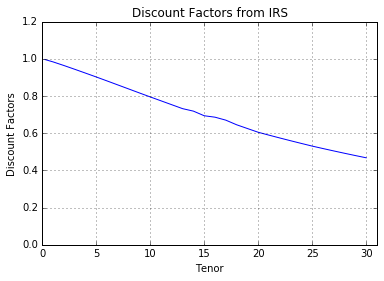

In [17]:
#plot discount curve
x = curve.sort_instr()
y = curve.get_df()
plt.plot(x,y)
plt.title("Discount Factors from IRS")
plt.xlabel("Tenor")
plt.ylabel("Discount Factors")
plt.grid('on')

#set limits
plt.xlim(0,31)
plt.ylim(0, 1.2)

plt.show()

In [36]:
'''scrap paper'''
#0.016031,  Y1
#0.017877999999999998,  Y2
#0.019050999999999998,  Y3
#0.019889999999999998,   Y4
#0.020573000000000001)' Y5

df1 = (1 - 0.0)/ (1 + USSA.iloc[0,0]*365/360)

df2 = (1 - df1 * USSA.iloc[0, 1]*365/360)  / (1 + USSA.iloc[0,1]*365/360)

df3 = (1 - ((df1 + df2)* USSA.iloc[0, 2]*365/360))  / (1 + USSA.iloc[0,2]*365/360)

df4 = (1 - ((df1 + df2 + df3) * USSA.iloc[0, 3]*365/360)) / (1 + USSA.iloc[0,3]*365/360)
       
df5 = (1 - ((df1 + df2 + df3 + df4)* USSA.iloc[0, 4]*365/360)) / (1 + USSA.iloc[0,4]*365/360)

df_tuple = df1, df2, df3, df4, df5

year = 1

for i in df_tuple:
    
    print('year '+str(year)+ ' '  + str(i) )
    year += 1


sumcoup2 = (df1) * 0.017877999999999998
sumcoup3 = (df1 + df2 ) * 0.019050999999999998
sumcoup4 = (df1 + df2 + df3)* 0.019889999999999998
sumcoup2 , sumcoup3, sumcoup4


[0, 1, 2, 3]


[0.9842219381101561,
 0.9646737217730607,
 0.9441196809193477,
 0.9230443855435724,
 0.9015956710035242]

In [ ]:
#THIS WORKS PERFECTLY
def get_df_list(n):
    
    '''
    (rate_n)*df1 + (rate_n)*df2 ...+ (1+ rate_n)*df_n = $1 
    Thus  df_n =  ($1 - sum(from 1 to n-1) *df[1 to n-1]  * r[n] )  / (1 + rate_n)'''
    
    rates = [0.016031, 0.017877999999999998, 0.019050999999999998,0.019889999999999998, 0.0205730000000000]
    
    df = [] #initiailze
   
    #populate 1st year discount factor 
    df.insert(0, 1/(1+rates[0]))
    
    for i in range(1, len(rates)):
        sum_df = 0
        j_vec = []
        #for j in range(0, len(rates)-1): #IndexError: list index out of range
        for j in range(0, i):
            j_vec.append(j)
            sum_df +=  df[j] * rates[i]*(365/360)    
        df.append((1-sum_df)/(1+rates[i]*365/360))
    print(j_vec)
         
    return(df)
        
get_df_list(3)

In [37]:
def get_df_dictio(n):
    
    rates_keys = [1, 2, 3, 4, 5]
    rates_val = [0.016031, 0.017877999999999998, 0.019050999999999998,0.019889999999999998, 0.0205730000000000]
    zipped = list(zip(rates_keys, rates_val))
    rates = dict(zipped)
    (coup) = rates
    
    #populate 1st year discount factor 
    df = {}
    df[1] = 1/(1+rates[1])
    
    for i in range(2, len(rates)+1):
        sum_df = 0
        #print('i '+str(n))
        
        for j in range(1, i):
            #print(j)
            #print('df[j] '+str(df[j]))
            sum_df +=  df[j] * rates[i]*(365/360)    
        df[i] = ((1-sum_df)/(1+rates[i]*365/360))
        
    return(df)
        
get_df_dictio(6)

{1: 0.9842219381101561,
 2: 0.9646737217730607,
 3: 0.9441196809193477,
 4: 0.9230443855435724,
 5: 0.9015956710035242}

In [51]:
dictio = {}
def add_instr2(par, T, coup, price, freq = 1):
    dictio[T] = (par, coup, price, freq)
    
add_instr2(1, 1, 0.016031, 1)  #Year 1   
add_instr2(1, 2, 0.017877999999999998, 1) #Year 2   
add_instr2(1, 3, 0.019050999999999998, 1) #Year 3  
add_instr2(1, 4, 0.019889999999999998, 1) #Year 4
dictio


{1: (1, 0.016031, 1, 1),
 2: (1, 0.017877999999999998, 1, 1),
 3: (1, 0.019051, 1, 1),
 4: (1, 0.019889999999999998, 1, 1)}